## System RUL

In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import torch
import matplotlib.pyplot as plt
from src.models.particle_filter.core import ParticleFilter
from src.models.networks.pf_mlp import ParticleFilterMLP
from src.models.rul_predictor import RULPredictor

from src.helpers.visualization import plot_rul_from_dataframe
from src.helpers.seed import set_global_seed

from experiment_config import (
    DegModel,DATA_NAME,ESTIMATION_NAME,SEED,PFNET_NAME,LEAKY_SLOPE,HIDDEN_DIMS,PREDICTION_START_IDX, N_REP,UNCERTAINTY_LEVEL,PRED_STAT
)

DATA_NAME

'DS06'

## Parameters

In [2]:
# PF parameters
n_particles = 1800

## Plot resolution
t_grid = np.linspace(0.1, 100, 80) 
s_grid = np.linspace(0.0, 1.0, 60)

In [3]:
activation = torch.nn.LeakyReLU(LEAKY_SLOPE)
set_global_seed(SEED)

estimation_dir = Path('experiments')/DATA_NAME/ESTIMATION_NAME
degmodel_dir = estimation_dir/DegModel.name()
pfnet_dir = degmodel_dir /'pf_performs'/PFNET_NAME
pred_dir = pfnet_dir/f"pred_{PRED_STAT}"
pred_dir.mkdir(parents=True, exist_ok=True)

## Load pf-models

In [4]:
hi_df = pd.read_csv(estimation_dir/"data_dev.csv")
dev_units = hi_df['unit'].astype(int).unique().tolist()
perform_names = [col for col in hi_df.columns if col not in ['unit','cycle','hs']]
del hi_df

dev_units 

[1, 2, 3, 4, 5, 6]

In [5]:
pfs = {}
for perform_name in perform_names:
	# load pf-network
	net = ParticleFilterMLP(state_dim=DegModel.state_dim(), hidden_dims=HIDDEN_DIMS,
                        activation=lambda : activation)
	ckpt = torch.load(pfnet_dir/perform_name/'checkpoint.pt', weights_only=False)
	net.load_state_dict(ckpt['model_state'])
	net = net.eval() 
	
	degmodels = []
	for unit in dev_units:
		best_model = DegModel()
		best_model.load_state_dict(
			torch.load(degmodel_dir/'states'/perform_name/f'unit_{unit}'/ "best_model.pt")
		)
		best_model
		degmodels.append(best_model)
  
	perform_pf = ParticleFilter(
									base_models = degmodels,
									net = net,
									n_particles=n_particles,
         							)
	pfs[perform_name] = perform_pf

## Create System RUL

In [6]:
rul_pred = RULPredictor(pf_models=pfs,current_obs=False,conf_level=UNCERTAINTY_LEVEL,pred_stat=PRED_STAT)

## Import test data


In [7]:
hi_df = pd.read_csv(estimation_dir/'data_test.csv')
test_units = hi_df['unit'].astype(int).unique().tolist()
test_units

[7, 8, 9, 10]

In [8]:
performs = {name: 
    {unit: hi_df[hi_df['unit']==unit][name].values for unit in test_units} 
    for name in perform_names
}
time = {unit: hi_df[hi_df['unit']==unit]['cycle'].values for unit in test_units}
onsets = {unit: hi_df[(hi_df['unit']==unit) & (hi_df['hs']==0)]['cycle'].values[0] for unit in test_units}

del hi_df['hs']

## Prepare data

In [9]:
test_data = {}
for name, perform_units in performs.items():
    test_perform_data = {}
    for unit in test_units:
        t_data = time[unit]
        s_data = perform_units[unit]
        test_perform_data[unit]=torch.tensor(np.stack([t_data, s_data],axis=1),dtype=torch.float32)
    test_data[name]=test_perform_data

## System RUL

In [ ]:
preds:list[pd.DataFrame] = []  

for rep in range(N_REP):
    print(f"Starting repetition {rep+1}/{N_REP}...")
    rul_pred.reset()
    for test_unit in test_units:
        print(f"Processing unit {test_unit}...")
        s_data = {name: performs[name][test_unit] for name in perform_names}
        t_data = time[test_unit]
        eol_time = time[test_unit][-1]
     
        rul_pred.predict(
                t_data=t_data,
                s_data=s_data,
                start_idx=PREDICTION_START_IDX,
            )
        # Collect predictions
        df = rul_pred.history_to_dataframe()
        df["rep"] = rep 
        df["unit"] = test_unit
        df["true_rul"] = np.maximum(eol_time - df['time'], 0.0)
        preds.append(df)
    
preds_df = pd.concat(preds, ignore_index=True)
preds_df.to_csv(pred_dir/ f"rul_test_predictions_rep{N_REP}.csv", index=False)


Starting repetition 1/10...
Processing unit 7...
Processing unit 8...
Processing unit 9...
Processing unit 10...
Starting repetition 2/10...
Processing unit 7...
Processing unit 8...
Processing unit 9...
Processing unit 10...
Starting repetition 3/10...
Processing unit 7...
Processing unit 8...
Processing unit 9...
Processing unit 10...
Starting repetition 4/10...
Processing unit 7...


# Plot final RUL predictions

In [ ]:
df_preds = pd.read_csv(pred_dir /  f"rul_test_predictions_rep{N_REP}.csv")
pred_dir

PosixPath('experiments/DS05/estimation_thr0.1_q0.01-0.99_filtered_n0.01_s20.0/gamma_onset0.2-0.2/pf_performs/net256x256x128x64x32leaky0.05_emaloss0.9_init0/pred_mean')

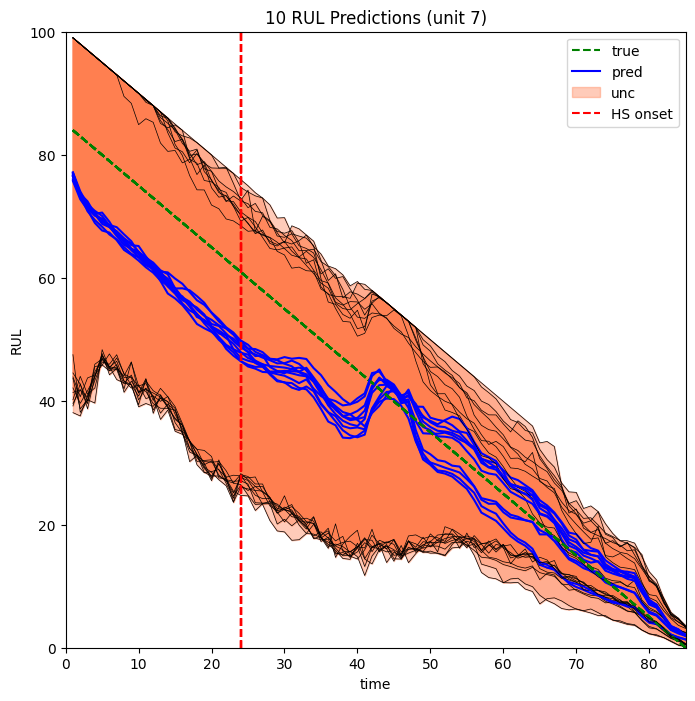

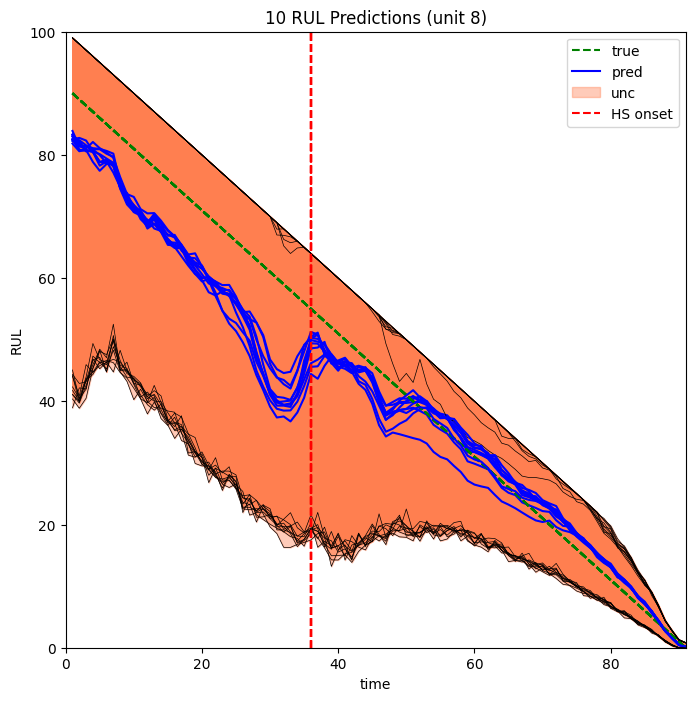

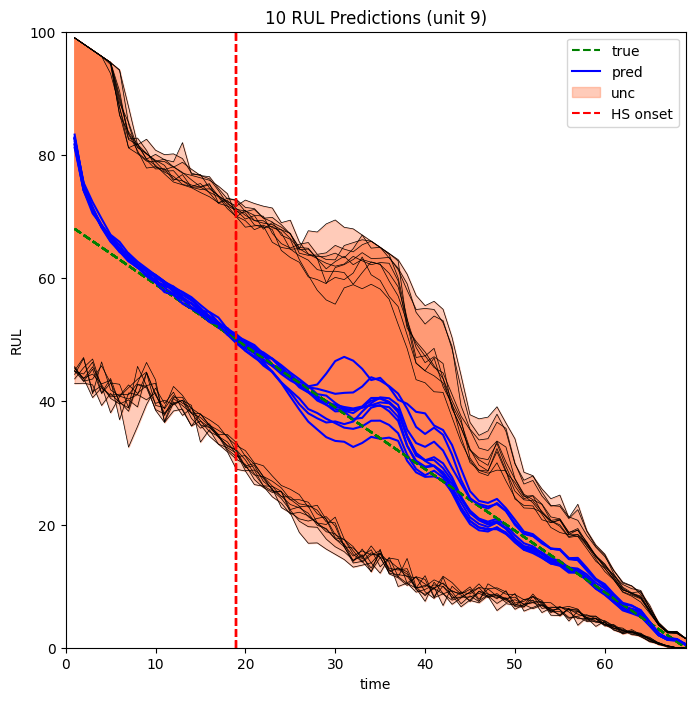

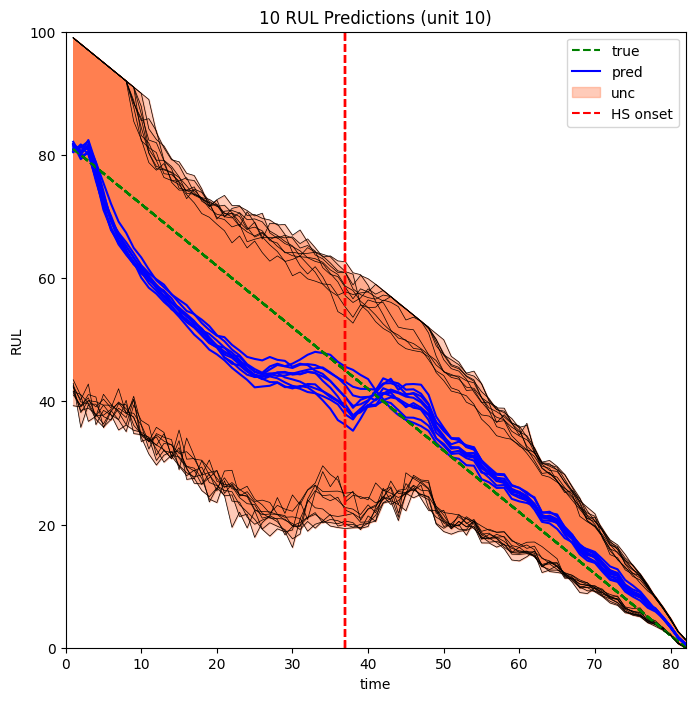

In [ ]:
for unit in test_units:
	fig, ax = plt.subplots(figsize=(8, 8))
	for rep in range(N_REP):
		df = df_preds[(df_preds['unit']==unit) & (df_preds['rep']==rep)]
		eol_time = df['time'].iloc[-1]
		plot_rul_from_dataframe(ax=ax, df=df,t_max=eol_time,
				title=f"{N_REP} RUL Predictions (unit {unit})", show_legend=False if rep else True)
		ax.vlines(onsets[unit], ymin=0, ymax=100, colors='red', linestyles='dashed', label='HS onset' if rep==0 else None)
	ax.legend()
	fig.savefig(pred_dir/  f'rul_test_eval{unit}_rep{N_REP}.png')

## inal RUL Mean Prediction

In [ ]:
df_preds = df_preds.groupby(["unit", "time"], as_index=False).mean()

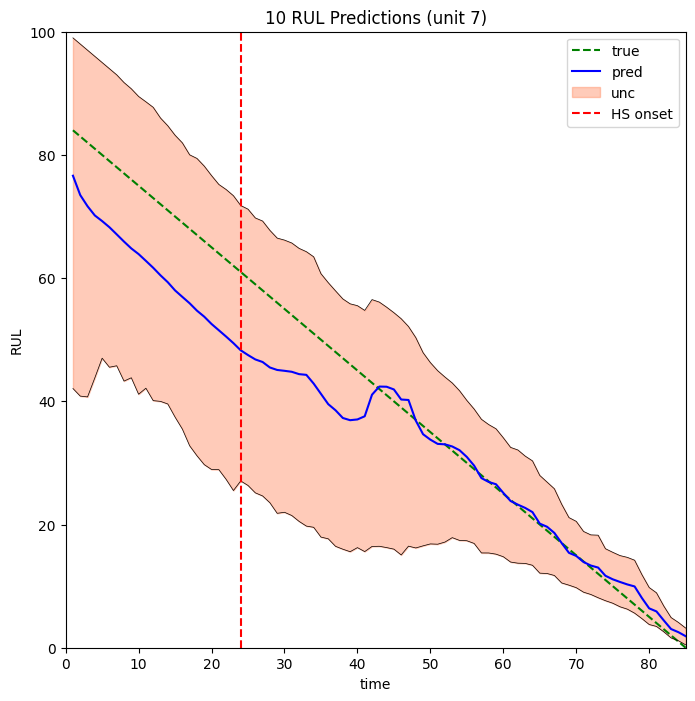

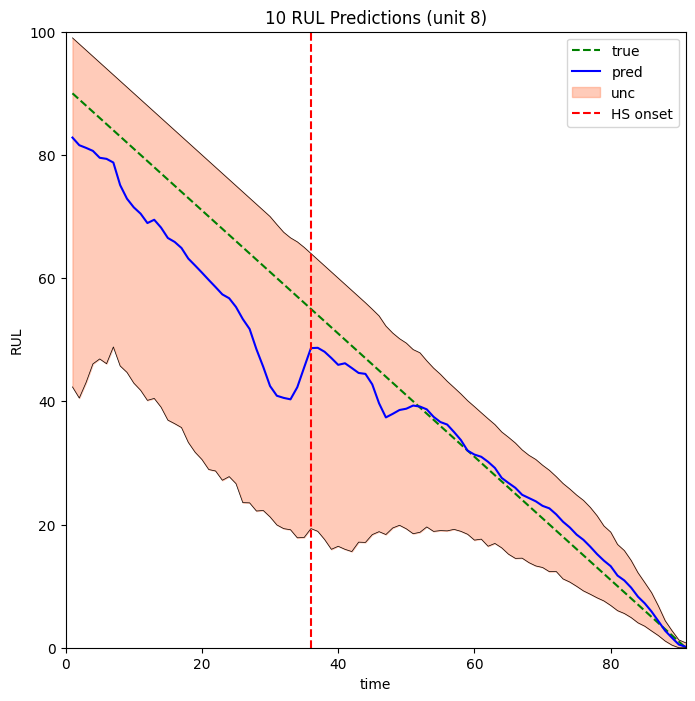

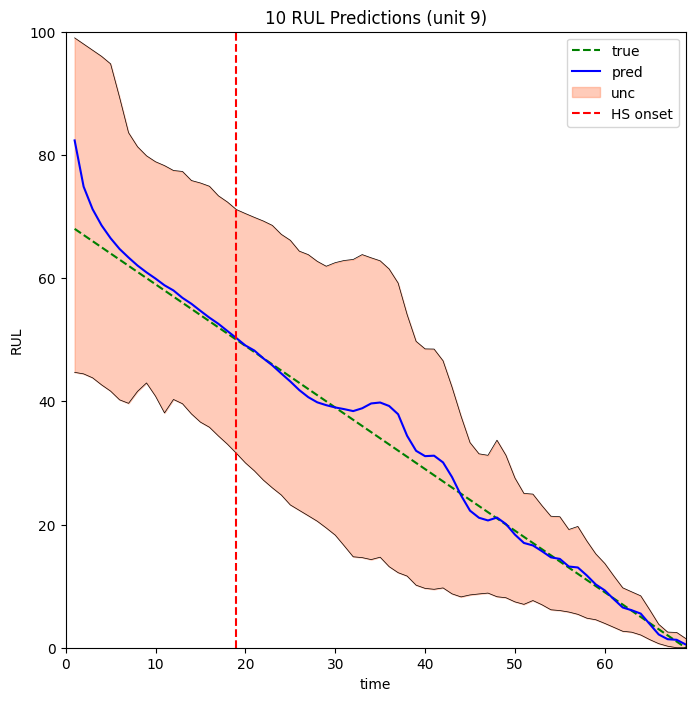

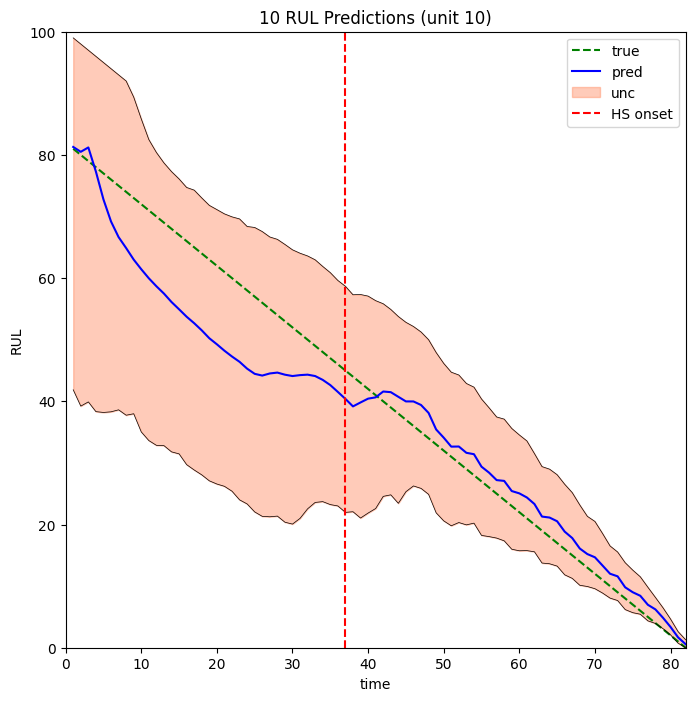

In [ ]:
df_preds = df_preds.groupby(["unit", "time"], as_index=False).mean()
for unit in test_units:
    fig, ax = plt.subplots(figsize=(8, 8))
    df = df_preds[df_preds['unit']==unit]
    eol_time = df['time'].iloc[-1]
    plot_rul_from_dataframe(ax=ax, df=df,t_max=eol_time,
            title=f"{N_REP} RUL Predictions (unit {unit})", show_legend= True)
    ax.vlines(onsets[unit], ymin=0, ymax=100, colors='red', linestyles='dashed', label='HS onset')
    ax.legend()
    fig.savefig(pred_dir/  f'rul_test_eval{unit}_avg{N_REP}.png')
    
    
    # Light red region from HS onset to end of life
    # ax.axvspan(
    #     0,
    #     eol_time,
    #     color='grey',
    #     alpha=0.18,  # transparency (small = lighter)
    # )
 